In [1]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split

import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (Dense, LSTM, Flatten, CuDNNLSTM, GRU, Conv1D, 
                          MaxPooling1D,Dropout, Bidirectional, Flatten)
from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import (accuracy_score, classification_report, precision_score,
                     recall_score, f1_score, roc_auc_score, roc_curve, auc)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [2]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [3]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [4]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

2022-10-29 21:28:28.760307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:28:28.761263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:28:29.296617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:28:29.297564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:28:29.298373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

we have 780 items in X 


In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=20)


In [7]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [8]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [9]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

# Building Model with files

In [10]:
X_train_f, X_split_f, y_train_f, y_split_f = train_test_split(X, y, test_size=0.30, random_state=42)
X_test_f, X_valid_f, y_test_f, y_valid_f = train_test_split(X_split_f, y_split_f, test_size=0.50, random_state=42)

In [11]:
# X_train_f = X_train_f.reshape(X_train_f.shape[0] , X_train_f.shape[1]*X_train_f.shape[2])
# X_valid_f = X_valid_f.reshape(X_valid_f.shape[0] , X_valid_f.shape[1]*X_valid_f.shape[2])
# X_test_f = X_test_f.reshape(X_test_f.shape[0] , X_test_f.shape[1]*X_test_f.shape[2])

X_train_f = X_train_f.reshape(len(X_train_f), X_train_f.shape[1],18)
X_valid_f = X_valid_f.reshape(len(X_test_f), X_test_f.shape[1],18)
X_test_f = X_test_f.reshape(len(X_valid_f), X_valid_f.shape[1],18)

In [12]:
print(X_train_f.shape)
print(X_test_f.shape)

(546, 400, 18)
(117, 400, 18)


In [13]:
y_train_f = to_categorical(y_train_f)
y_test_f=to_categorical(y_test_f)
y_valid_f=to_categorical(y_valid_f)

In [14]:
# Model architecture
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape =(400,18)))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Bidirectional(CuDNNLSTM(units=128, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(units=64, return_sequences=True)))
model.add(Flatten())
model.add(Dense(26,activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 128)          7040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 132, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 43, 256)           198656    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 43, 128)           164864    
_________________________________________________________________
flatten (Flatten)            (None, 5504)              0

In [16]:
import tensorflow as tf


model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)

history = model.fit(X_train_f, y_train_f, batch_size=128, epochs=100, 
                    validation_data=(X_valid_f, y_valid_f),
                    callbacks=[es,checkpointer,csv_logger])

model.save("./lstm.hdf5")

2022-10-29 21:28:45.219467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-29 21:28:50.027499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 19s 258ms/step - loss: 3.1659 - accuracy: 0.1355 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5311 - val_accuracy: 0.2137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 2.1519 - accuracy: 0.3938 - precision: 1.0000 - recall: 0.0128 - val_loss: 1.5593 - val_accuracy: 0.6068 - val_precision: 0.7826 - val_recall: 0.1538
Epoch 3/100
5/5 [==============================] - 0s 30ms/step - loss: 1.2040 - accuracy: 0.6813 - precision: 0.8844 - recall: 0.2802 - val_loss: 1.2180 - val_accuracy: 0.5983 - val_precision: 0.7391 - val_recall: 0.2906
Epoch 4/100
5/5 [==============================] - 0s 30ms/step - loss: 0.7344 - accuracy: 0.7985 - precision: 0.9284 - recall: 0.6172 - val_loss: 0.6145 - val_accuracy: 0.8462 - val_precision: 0.9121 - val_recall: 0.7094
Epoch 5/100
5/5 [==============================] - 0s 30ms/step - loss: 0.4997 - accuracy: 0.8425 - precis

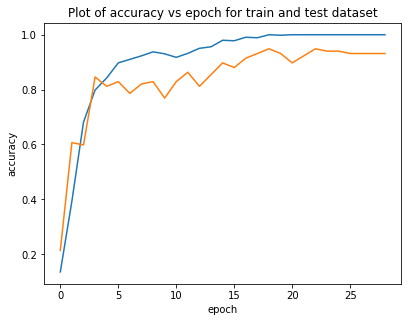

In [17]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

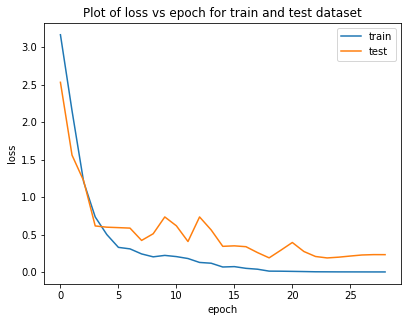

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Model Evaluation

In [19]:
test_results = model.evaluate(X_test_f, y_test_f, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')
print(f'Test results - Precision: {test_results[2]*100} - Recall: {test_results[3]*100}%')

4/4 [==============================] - 0s 18ms/step - loss: 0.2688 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402
Test results - Loss: 0.26882439851760864 - Accuracy: 94.017094373703%
Test results - Precision: 94.017094373703 - Recall: 94.017094373703%


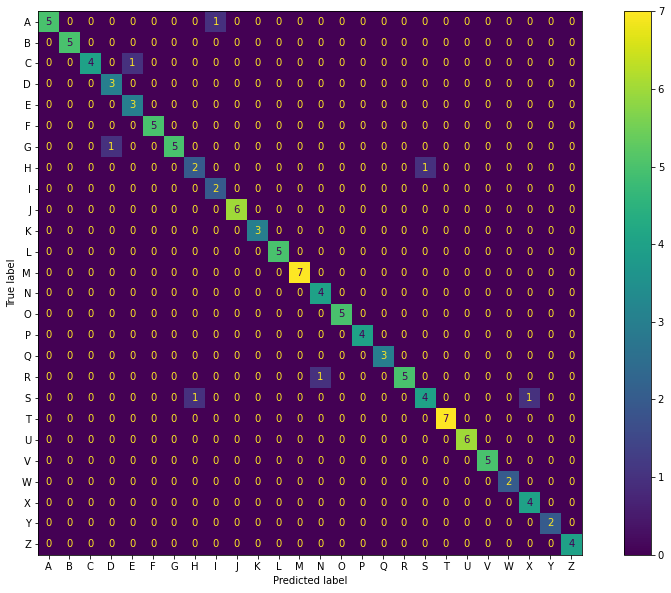

In [20]:
#Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_predictions = model.predict(X_test_f)
cm=confusion_matrix(y_test_f.argmax(axis=1),y_predictions.argmax(axis=1))

clss = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clss)

plt.rcParams["figure.figsize"] = 15, 10
disp.plot()
plt.show()


In [21]:
#Classification Report

from sklearn.metrics import classification_report

report = classification_report(y_test_f.argmax(axis=1),y_predictions.argmax(axis=1), target_names=clss)
print(report)

              precision    recall  f1-score   support

           A       1.00      0.83      0.91         6
           B       1.00      1.00      1.00         5
           C       1.00      0.80      0.89         5
           D       0.75      1.00      0.86         3
           E       0.75      1.00      0.86         3
           F       1.00      1.00      1.00         5
           G       1.00      0.83      0.91         6
           H       0.67      0.67      0.67         3
           I       0.67      1.00      0.80         2
           J       1.00      1.00      1.00         6
           K       1.00      1.00      1.00         3
           L       1.00      1.00      1.00         5
           M       1.00      1.00      1.00         7
           N       0.80      1.00      0.89         4
           O       1.00      1.00      1.00         5
           P       1.00      1.00      1.00         4
           Q       1.00      1.00      1.00         3
           R       1.00    

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

n_classes = len(clss)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clss)):
    fpr[i], tpr[i], _ = roc_curve(y_test_f[:, i], y_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_f.ravel(), y_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

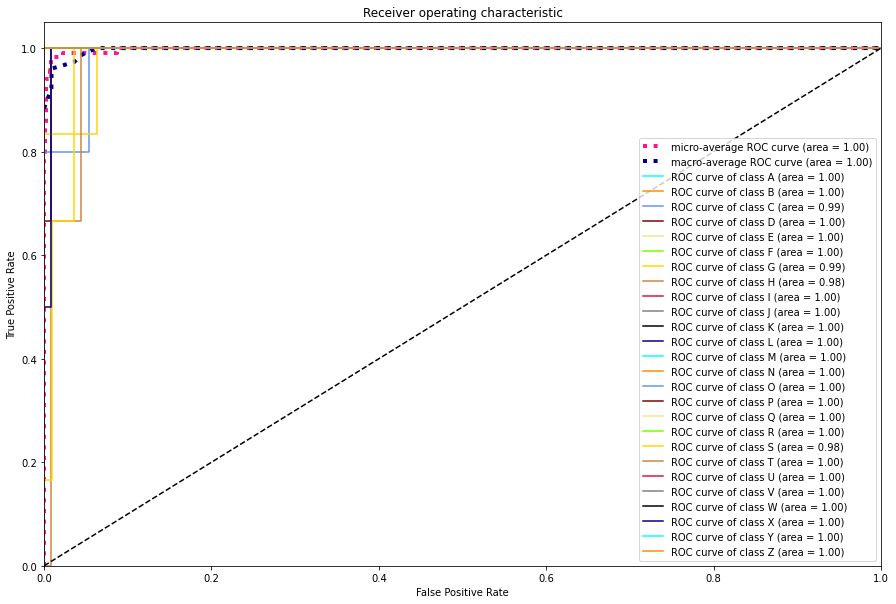

In [23]:
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "maroon","khaki", "lawngreen", "gold", "peru","crimson", "gray", "black", "navy"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label=f"ROC curve of class {clss[i]} (area = {roc_auc[i]:0.2f})",
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()